This notebook causes kernel deaths

The reason seems to be distribution of computation over too many threads that are used 100%. The solution is to limit the number of threads in the following prep cell, and changing some of the Jupyter config options:

    c.MappingKernelManager.cull_idle_timeout = 300 # Wait longer
    c.KernelManager.transport_wait_time = 60.0 # Allow 60s silence (Default is often ~3s)

In [1]:
# ===========================
# Cell Prelim - Kernel crashes
# ===========================

import os

# 1. LIMIT THREADS TO P-CORES ONLY
# The i9-13900K has 8 Performance cores. 
# We set this to 8 to avoid HyperThreading overhead (safest) 
# or 16 to use P-core HyperThreading (might be faster, might be unstable).
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["TORCH_NUM_THREADS"] = "8"

# 2. OPTIONAL: INTEL SPECIFIC PINNING
# This forces the threads to stick to the physical cores and stop "swapping"
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"

In [2]:
# ===========================
# Cell 0 — Config
# ===========================
import numpy as np

# Three separate qae_runs folders (one per architecture)
QAE_RUNS_ROOTS = {
    "monolith": "../Monolith_QAE/qae_runs",
    "sidekick": "../Sidekick_QAE/qae_runs",
    "stacked": "../Stacked_QAE/qae_runs"
}

# Data root (shared across all architectures)
DATA_ROOT = "../data"

# Output directory for framework results
FRAMEWORK_OUT = "./eval_results"

# Datasets to evaluate (explicit list for determinism)
DATASETS = [
    "mackey_glass_tau17_n200",
    "mackey_glass_tau30_n200"
]

# Evaluation parameters
# (Matching monolith training noise; can be changed as needed)
TEST_NOISE_LEVELS = [0.2]
TEST_SEED_BASE = 99123  # Base seed for deterministic test set generation

# Toggle detailed plots
MAKE_PLOTS = True
SAVE_INDIVIDUAL_BUNDLES = True  # (not used yet; reserved for future)

# Path filter (set to None to include all architectures)
# Example: ARCH_FILTER = "4q_2l_2t" to test only 4-qubit models
ARCH_FILTER = None

In [3]:
# ===========================
# Cell 1 — Imports & Utilities
# ===========================
import os, json, re, sys, time
from pathlib import Path
from typing import Dict, Any, Tuple, List, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pennylane as qml
from pennylane import numpy as pnp

# Optional SciPy for p-values
try:
    from scipy import stats as sp_stats
    HAVE_SCIPY = True
except ImportError:
    HAVE_SCIPY = False
    print("Warning: SciPy not found. p-values will be approximated or set to NaN.")

# Add paths for qae_utils
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from qae_utils.Files import read_json_file, read_ts_file
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg, ts_add_noise

# Create output directory
Path(FRAMEWORK_OUT).mkdir(parents=True, exist_ok=True)

# Print formatting
np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (12, 6)

print("Framework initialized.")
print(f"Output directory: {FRAMEWORK_OUT}")
print(f"Datasets: {DATASETS}")


def x2y(x, xlim=(0, 1), ylim=(0, np.pi)):
    """Scale values from xlim range to ylim range (vectorized)."""
    low_x, high_x = xlim
    low_y, high_y = ylim
    input_range_length = high_x - low_x
    if np.isclose(input_range_length, 0.0):
        return (low_y + high_y) / 2
    scaling_factor = (high_y - low_y) / input_range_length
    return low_y + (x - low_x) * scaling_factor

Framework initialized.
Output directory: ./eval_results
Datasets: ['mackey_glass_tau17_n200', 'mackey_glass_tau30_n200']


In [4]:
# ===========================
# Cell 2 — Data Loading
# ===========================

def load_dataset(data_id: str) -> Tuple[np.ndarray, Dict[str, float]]:
    """Load dataset with robust path searching."""
    candidates = [
        Path(DATA_ROOT) / data_id,
        Path("../data") / data_id,
        Path("../../data") / data_id,
        Path("../dev/data") / data_id,
    ]
    
    for folder in candidates:
        info_path = folder / "info.json"
        y_path = folder / "y_org.arr"
        
        if info_path.exists() and y_path.exists():
            info = read_json_file(str(info_path))
            y = read_ts_file(str(y_path))
            
            return np.asarray(y), {
                "scale_low": float(info["scale_low"]),
                "scale_high": float(info["scale_high"]),
                "folder": str(folder.resolve())
            }
    
    raise FileNotFoundError(f"Dataset '{data_id}' not found in: {[str(c) for c in candidates]}")


def generate_test_windows(
    y: np.ndarray,
    sigma: float,
    seed: int,
    wind_size: int,
    wind_step: int,
    split: float,
    scale_low: float,
    scale_high: float,
    noise_clip: bool = True
) -> Tuple[np.ndarray, ...]:
    """Generate clean and noisy windows with deterministic seed."""
    y_noisy = ts_add_noise(
        y, noise=sigma, noise_type='normal', clip=noise_clip,
        range_low=scale_low, range_high=scale_high, seed=int(seed)
    )
    
    win_clean = ts_wind_make(y, wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i * wind_step for i in range(len(win_clean))])
    
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    
    return (np.asarray(tr_clean), np.asarray(tr_noisy),
            np.asarray(te_clean), np.asarray(te_noisy))


def flatten_avg(windows, wind_step):
    """Flatten overlapping windows by averaging."""
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)


def mse(a, b):
    """Calculate mean squared error."""
    return float(np.mean((np.asarray(a) - np.asarray(b)) ** 2))


print("Data utilities loaded.")

Data utilities loaded.


In [5]:
# ===========================
# Cell 3 — Bundle Discovery
# ===========================

def find_bundles_for_dataset(data_id: str) -> Dict[str, List[Path]]:
    """Find all bundle files organized by architecture type."""
    bundles = {
        "monolith": [],
        "sidekick": [],
        "stacked": []
    }
    
    for arch_type, root_path in QAE_RUNS_ROOTS.items():
        root = Path(root_path) / data_id
        
        if not root.exists():
            print(f"{arch_type.capitalize()} root not found: {root.resolve()}")
            continue
        
        print(f"Searching {arch_type.capitalize()} in: {root.resolve()}")
        
        bundle_count = 0
        for bundle_path in root.rglob("bundle_*.json"):
            if ARCH_FILTER and ARCH_FILTER not in str(bundle_path):
                continue
            bundles[arch_type].append(bundle_path.resolve())
            bundle_count += 1
        
        print(f"  Found {bundle_count} bundles for {arch_type}")
    
    return bundles


def parse_bundle(bundle_path: Path) -> Dict[str, Any]:
    """Parse bundle JSON and extract key information."""
    with open(bundle_path, 'r', encoding='utf-8') as f:
        bundle = json.load(f)
    
    schema = bundle.get("schema", {})
    dataset = bundle.get("dataset", {})
    run = bundle.get("run", {})
    env = bundle.get("environment", {})
    arch = bundle.get("architecture", {})
    params = bundle.get("parameters", {})
    
    schema_name = (schema.get("name", "") or "").lower()
    if "monolith" in schema_name:
        arch_type = "monolith"
    elif "sidekick" in schema_name:
        arch_type = "sidekick"
    elif "stacked" in schema_name:
        arch_type = "stacked"
    else:
        path_str = str(bundle_path).lower()
        if "monolith" in path_str:
            arch_type = "monolith"
        elif "sidekick" in path_str:
            arch_type = "sidekick"
        elif "stacked" in path_str:
            arch_type = "stacked"
        else:
            arch_type = "unknown"
    
    return {
        "bundle_path": bundle_path,
        "arch_type": arch_type,
        "dataset_id": dataset.get("id", "unknown"),
        "window_size": int(dataset.get("window_size", arch.get("n_qubits", 0))),
        "window_step": int(dataset.get("window_step", 1)),
        "split": float(dataset.get("split", 0.75)),
        "scale_low": float(dataset.get("scale_low", 0)),
        "scale_high": float(dataset.get("scale_high", 1)),
        
        "n_qubits": int(arch.get("n_qubits", 0)),
        "n_latent": int(arch.get("n_latent", 0)),
        "n_trash": int(arch.get("n_trash", 0)),
        "n_extra": int(arch.get("n_extra", 0)),
        "rot": arch.get("rot", "Rxyz"),
        
        "layer": int(run.get("layer", 1)),
        "instance_id": int(run.get("instance_id", -1)),
        "device_seed": int(run.get("device_seed", 0)),
        
        "device": env.get("device", "lightning.qubit"),
        "diff_method": env.get("diff_method", "adjoint"),
        "interface": env.get("interface", "autograd"),
        
        "weights_s1": np.array(params.get("weights_stage1", params.get("weights", []))),
        "weights_s2": np.array(params.get("weights_stage2", [])),
        
        "training_noise": float(run.get("sigma_eval", 0.2)),
        "test_seed_original": int(run.get("test_seed_fixed", TEST_SEED_BASE)),
        
        "full_bundle": bundle
    }


print("Bundle discovery functions ready.")

Bundle discovery functions ready.


In [6]:
# ===========================
# Cell 4 — Monolith QAE Rebuilder
# ===========================

def build_monolith_qae(config: Dict[str, Any]) -> Tuple[qml.QNode, np.ndarray]:
    """
    Rebuild Monolith QAE exactly as in the training notebook.
    Returns a tuple of (QNode, optimal_weights).
    """
    n_latent = config["n_latent"]
    n_trash = config["n_trash"]
    n_extra = config.get("n_extra", 0)
    n_layers = config["layer"]
    rot = config["rot"]
    
    weights_raw = config["weights_s1"]
    if weights_raw is None or len(weights_raw) == 0:
        raise ValueError("Monolith weights not found in 'weights_s1'.")

    n_data = n_latent + n_trash
    n_anz = n_data + n_extra
    n_zero = n_trash + n_extra
    n_wires = n_latent + 2 * n_trash + 2 * n_extra
    
    wires = list(range(n_wires))
    dev = qml.device(config["device"], wires=n_wires, shots=None, seed=config["device_seed"])
    
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent + n_trash]
    extra_wires = wires[n_data:n_data + n_extra]
    zero_wires = wires[n_anz:n_anz + n_zero]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires + extra_wires

    def _full_qae_circuit_def(weights, inputs):
        """The circuit definition, matching the monolith training notebook."""
        qml.AngleEmbedding(inputs, wires=data_wires, rotation='Y')
        qml.Barrier(wires)

        def _entangler_shape(n_layers, n_wires, rot):
            if rot == 'Ry':
                return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
            else:
                return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

        def _entangler(wires, weights, rot):
            if rot == 'Ry':
                qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
            else:
                qml.StronglyEntanglingLayers(weights, wires=wires)

        enc_weights_shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        dec_weights_shape = enc_weights_shape

        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        _entangler(anz_wires, enc_weights, rot=rot)

        qml.Barrier(wires)
        # SWAP trash and extra with zeros
        for i in range(len(trash_wires)):
            qml.SWAP(wires=[trash_wires[i], zero_wires[i]])
        for i in range(len(extra_wires)):
            qml.SWAP(wires=[extra_wires[i], zero_wires[len(trash_wires) + i]])
        qml.Barrier(wires)

        qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        qml.Barrier(wires)

        return [qml.expval(qml.PauliZ(w)) for w in data_wires]

    qae_model = qml.QNode(
        _full_qae_circuit_def,
        dev,
        interface=config["interface"],
        diff_method=config["diff_method"]
    )
    
    optimal_weights = pnp.array(weights_raw, requires_grad=False)
    return qae_model, optimal_weights


print("Monolith rebuilder ready.")

Monolith rebuilder ready.


In [7]:
# ===========================
# Cell 5 — Sidekick & Stacked QAE Rebuilders
# ===========================

def build_sidekick_qae(config: Dict[str, Any]) -> qml.QNode:
    """Rebuild Sidekick QAE."""
    n_latent = config["n_latent"]
    n_trash = config["n_trash"]
    n_layers = config["layer"]
    rot = config["rot"]
    
    weights_s1 = config["weights_s1"]
    weights_s2 = config["weights_s2"]
    
    n_wires = n_latent + 2 * n_trash
    wires = list(range(n_wires))
    dev = qml.device(config["device"], wires=n_wires, shots=None, seed=config["device_seed"])
    
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent + n_trash]
    zero_wires = wires[n_latent + n_trash:n_latent + 2 * n_trash]
    data_wires = latent_wires + trash_wires
    
    def _entangler_shape(n_layers, n_wires, rot):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

    def _entangler(weights, wires, rot):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
        else:
            qml.StronglyEntanglingLayers(weights, wires=wires)
            
    shape = _entangler_shape(n_layers, len(data_wires), rot)
    
    if weights_s2 is None or weights_s2.size == 0:
        weights_flat = weights_s1.flatten()
        split_idx = np.prod(shape)
        enc_weights = weights_flat[:split_idx].reshape(shape)
        dec_weights = weights_flat[split_idx:split_idx*2].reshape(shape)
    else:
        dec_weights = weights_s1.reshape(shape)
        enc_weights = weights_s2.reshape(shape)
    
    def _sequence_encoder(wires, inputs):
        for i in range(len(wires)):
            if i < len(inputs):
                qml.RY(inputs[i], wires=wires[i])
            else:
                qml.RY(0.0, wires=wires[i])
    
    @qml.qnode(dev, interface=config["interface"], diff_method=config["diff_method"])
    def qae_circuit(inputs):
        _sequence_encoder(data_wires, inputs)
        _entangler(enc_weights, data_wires, rot)
        
        qml.Barrier(wires)
        for i in range(n_trash):
            qml.SWAP(wires=[trash_wires[i], zero_wires[i]])
        qml.Barrier(wires)
        
        qml.adjoint(_entangler)(dec_weights, data_wires, rot)
        
        # Sidekick-specific global X flip
        for q in data_wires:
            qml.PauliX(wires=q)
        
        return [qml.expval(qml.PauliZ(w)) for w in data_wires]
    
    return qae_circuit


def build_stacked_qae(config: Dict[str, Any]) -> qml.QNode:
    """Rebuild Stacked QAE."""
    n_latent = config["n_latent"]
    n_trash = config["n_trash"]
    n_layers = config["layer"]
    rot = config["rot"]
    
    weights_s1 = config["weights_s1"]
    weights_s2 = config["weights_s2"]
    
    n_wires = n_latent + 2 * n_trash
    wires = list(range(n_wires))
    dev = qml.device(config["device"], wires=n_wires, shots=None, seed=config["device_seed"])
    
    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent + n_trash]
    zero_wires = wires[n_latent + n_trash:n_latent + 2 * n_trash]
    data_wires = latent_wires + trash_wires
    
    def _entangler_shape(n_layers, n_wires, rot):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

    def _entangler(weights, wires, rot):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
        else:
            qml.StronglyEntanglingLayers(weights, wires=wires)
            
    shape = _entangler_shape(n_layers, len(data_wires), rot)
    
    if weights_s2 is None or weights_s2.size == 0:
        weights_flat = weights_s1.flatten()
        split_idx = np.prod(shape)
        enc_weights = weights_flat[:split_idx].reshape(shape)
        dec_weights = weights_flat[split_idx:split_idx*2].reshape(shape)
    else:
        dec_weights = weights_s1.reshape(shape)
        enc_weights = weights_s2.reshape(shape)
    
    def _sequence_encoder(wires, inputs):
        for i in range(len(wires)):
            if i < len(inputs):
                qml.RY(inputs[i], wires=wires[i])
            else:
                qml.RY(0.0, wires=wires[i])
    
    @qml.qnode(dev, interface=config["interface"], diff_method=config["diff_method"])
    def qae_circuit(inputs):
        _sequence_encoder(data_wires, inputs)
        _entangler(enc_weights, data_wires, rot)
        
        qml.Barrier(wires)
        for i in range(n_trash):
            qml.SWAP(wires=[trash_wires[i], zero_wires[i]])
        qml.Barrier(wires)
        
        qml.adjoint(_entangler)(dec_weights, data_wires, rot)
        
        return [qml.expval(qml.PauliZ(w)) for w in data_wires]
    
    return qae_circuit


print("Sidekick & Stacked rebuilders ready.")

Sidekick & Stacked rebuilders ready.


In [8]:
# ===========================
# Cell 6 — Model Evaluation Engine (with return_series + QMI)
# ===========================

def x2y(x, xlim=(0, 1), ylim=(0, np.pi)):
    """Scale values from xlim range to ylim range."""
    low_x, high_x = xlim
    low_y, high_y = ylim
    input_range_length = high_x - low_x
    if np.isclose(input_range_length, 0.0):
        return (low_y + high_y) / 2
    scaling_factor = (high_y - low_y) / input_range_length
    return low_y + (x - low_x) * scaling_factor


def evaluate_model_on_noise(
    model: qml.QNode,
    weights: Optional[np.ndarray],   # Weights can be None for sidekick/stacked
    config: Dict[str, Any],
    y_data: np.ndarray,
    noise_level: float,
    seed: int,
    return_series: bool = False,
) -> Dict[str, float] | Tuple[Dict[str, float], Dict[str, np.ndarray]]:
    """
    Evaluate a QAE model on test data with a specific noise level.

    - If return_series == False: returns a dict of scalar metrics.
    - If return_series == True: returns (metrics_dict, series_dict),
      where series_dict contains flattened time series for plotting.
    """

    # ---------- 1. Generate test windows ----------
    tr_clean, tr_noisy, te_clean, te_noisy = generate_test_windows(
        y_data,
        sigma=noise_level,
        seed=seed,
        wind_size=config["window_size"],
        wind_step=config["window_step"],
        split=config["split"],
        scale_low=config["scale_low"],
        scale_high=config["scale_high"],
        noise_clip=True,
    )

    arch_type = config["arch_type"]

    # ---------- 2. Architecture-specific encoding/decoding ranges ----------
    if arch_type == "monolith":
        # Monolith uses [0, π/4] for both encoding and decoding
        y_enc_low, y_enc_high = 0.0, np.pi / 4.0
        y_dec_low, y_dec_high = 0.0, np.pi / 4.0
    elif arch_type == "sidekick":
        # Sidekick typically encodes in [0, π], outputs in [-1, 1]
        y_enc_low, y_enc_high = 0.0, np.pi
        y_dec_low, y_dec_high = -1.0, 1.0
    elif arch_type == "stacked":
        # Stacked encodes in [-π, 0], outputs in [-1, 1]
        y_enc_low, y_enc_high = -np.pi, 0.0
        y_dec_low, y_dec_high = -1.0, 1.0
    else:
        raise ValueError(f"Unknown architecture type: {arch_type}")

    # Encode windows to the angle range used during training
    tr_n_enc = x2y(
        tr_noisy,
        xlim=(config["scale_low"], config["scale_high"]),
        ylim=(y_enc_low, y_enc_high),
    )
    te_n_enc = x2y(
        te_noisy,
        xlim=(config["scale_low"], config["scale_high"]),
        ylim=(y_enc_low, y_enc_high),
    )
    tr_c_enc = x2y(
        tr_clean,
        xlim=(config["scale_low"], config["scale_high"]),
        ylim=(y_enc_low, y_enc_high),
    )
    te_c_enc = x2y(
        te_clean,
        xlim=(config["scale_low"], config["scale_high"]),
        ylim=(y_enc_low, y_enc_high),
    )

    # ---------- 3. Helper to run a series of windows through the model ----------
    def _run(enc_windows: np.ndarray) -> np.ndarray:
        outs = []
        if weights is not None:
            for w in enc_windows:
                outs.append(np.asarray(model(weights, w)))
        else:
            for w in enc_windows:
                outs.append(np.asarray(model(w)))
        return np.stack(outs)

    # Inference on noisy and clean windows
    tr_hat_noisy = _run(tr_n_enc)
    te_hat_noisy = _run(te_n_enc)
    tr_hat_pure = _run(tr_c_enc)
    te_hat_pure = _run(te_c_enc)

    # ---------- 4. Flatten original series ----------
    tr_pure_flat = flatten_avg(tr_clean, config["window_step"])
    te_pure_flat = flatten_avg(te_clean, config["window_step"])
    tr_noisy_flat = flatten_avg(tr_noisy, config["window_step"])
    te_noisy_flat = flatten_avg(te_noisy, config["window_step"])

    # ---------- 5. Decode model outputs back to data scale ----------
    # Window-wise decoded outputs (for subspace metrics & QMI)
    tr_hat_noisy_dec_w = x2y(
        tr_hat_noisy,
        xlim=(y_dec_low, y_dec_high),
        ylim=(config["scale_low"], config["scale_high"]),
    )
    te_hat_noisy_dec_w = x2y(
        te_hat_noisy,
        xlim=(y_dec_low, y_dec_high),
        ylim=(config["scale_low"], config["scale_high"]),
    )
    tr_hat_pure_dec_w = x2y(
        tr_hat_pure,
        xlim=(y_dec_low, y_dec_high),
        ylim=(config["scale_low"], config["scale_high"]),
    )
    te_hat_pure_dec_w = x2y(
        te_hat_pure,
        xlim=(y_dec_low, y_dec_high),
        ylim=(config["scale_low"], config["scale_high"]),
    )

    # Flattened decoded outputs (for global MSE)
    tr_rec_noisy = x2y(
        flatten_avg(tr_hat_noisy, config["window_step"]),
        xlim=(y_dec_low, y_dec_high),
        ylim=(config["scale_low"], config["scale_high"]),
    )
    te_rec_noisy = x2y(
        flatten_avg(te_hat_noisy, config["window_step"]),
        xlim=(y_dec_low, y_dec_high),
        ylim=(config["scale_low"], config["scale_high"]),
    )
    tr_rec_pure = x2y(
        flatten_avg(tr_hat_pure, config["window_step"]),
        xlim=(y_dec_low, y_dec_high),
        ylim=(config["scale_low"], config["scale_high"]),
    )
    te_rec_pure = x2y(
        flatten_avg(te_hat_pure, config["window_step"]),
        xlim=(y_dec_low, y_dec_high),
        ylim=(config["scale_low"], config["scale_high"]),
    )

    # ---------- 6. Global MSE metrics ----------
    mse_tr_noise = mse(tr_pure_flat, tr_noisy_flat)
    mse_te_noise = mse(te_pure_flat, te_noisy_flat)
    mse_tr_rec_noisy = mse(tr_pure_flat, tr_rec_noisy)
    mse_te_rec_noisy = mse(te_pure_flat, te_rec_noisy)
    mse_tr_rec_pure = mse(tr_pure_flat, tr_rec_pure)
    mse_te_rec_pure = mse(te_pure_flat, te_rec_pure)

    delta_tr = 100.0 * (1.0 - mse_tr_rec_noisy / max(mse_tr_noise, 1e-12))
    delta_te = 100.0 * (1.0 - mse_te_rec_noisy / max(mse_te_noise, 1e-12))

    # ---------- 7. Latent vs trash MSEs + deltas (TEST, recovered from noisy) ----------
    n_latent = config["n_latent"]
    n_trash = config["n_trash"]
    n_data = n_latent + n_trash

    # Clamp in case metadata is slightly inconsistent
    n_data = min(n_data, te_clean.shape[1], te_hat_noisy_dec_w.shape[1])

    # Noise-only baselines
    mse_te_noise_latent = float(
        np.mean((te_clean[:, :n_latent] - te_noisy[:, :n_latent]) ** 2)
    )
    mse_te_noise_trash = float(
        np.mean((te_clean[:, n_latent:n_data] - te_noisy[:, n_latent:n_data]) ** 2)
    )

    # Recovered-from-noisy (window-wise) errors
    mse_te_rec_noisy_latent = float(
        np.mean((te_clean[:, :n_latent] - te_hat_noisy_dec_w[:, :n_latent]) ** 2)
    )
    mse_te_rec_noisy_trash = float(
        np.mean(
            (te_clean[:, n_latent:n_data] - te_hat_noisy_dec_w[:, n_latent:n_data]) ** 2
        )
    )

    delta_te_latent = 100.0 * (
        1.0 - mse_te_rec_noisy_latent / max(mse_te_noise_latent, 1e-12)
    )
    delta_te_trash = 100.0 * (
        1.0 - mse_te_rec_noisy_trash / max(mse_te_noise_trash, 1e-12)
    )

    # ---------- 8. Approximate Quantum Mutual Information (Gaussian proxy) ----------
    def _gaussian_mi(latent_arr: np.ndarray, trash_arr: np.ndarray):
        """
        Continuous mutual information estimate I(L;T) under a Gaussian assumption.

        Returns:
            (I(L;T), 0.5 log det Σ_LL, 0.5 log det Σ_TT)
        """
        X = latent_arr.reshape(latent_arr.shape[0], -1)
        Y = trash_arr.reshape(trash_arr.shape[0], -1)
        Z = np.concatenate([X, Y], axis=1)

        def _cov(mat):
            return np.cov(mat, rowvar=False)

        eps = 1e-9
        Σ_LL = _cov(X) + eps * np.eye(X.shape[1])
        Σ_TT = _cov(Y) + eps * np.eye(Y.shape[1])
        Σ_ZZ = _cov(Z) + eps * np.eye(Z.shape[1])

        det_LL = max(np.linalg.det(Σ_LL), eps)
        det_TT = max(np.linalg.det(Σ_TT), eps)
        det_ZZ = max(np.linalg.det(Σ_ZZ), eps)

        mi = 0.5 * np.log(det_LL * det_TT / det_ZZ)
        return float(max(mi, 0.0)), float(0.5 * np.log(det_LL)), float(
            0.5 * np.log(det_TT)
        )

    latent_out = te_hat_noisy_dec_w[:, :n_latent]
    trash_out = te_hat_noisy_dec_w[:, n_latent:n_data]

    try:
        qmi_total, qmi_latent, qmi_trash = _gaussian_mi(latent_out, trash_out)
    except Exception:
        qmi_total = qmi_latent = qmi_trash = float("nan")

    # ---------- 9. Pack metrics ----------
    metrics = {
        "mse_train_noise": float(mse_tr_noise),
        "mse_train_recovered_noisy": float(mse_tr_rec_noisy),
        "mse_train_recovered_pure": float(mse_tr_rec_pure),
        "delta_train_pct": float(delta_tr),
        "mse_test_noise": float(mse_te_noise),
        "mse_test_recovered_noisy": float(mse_te_rec_noisy),
        "mse_test_recovered_pure": float(mse_te_rec_pure),
        "delta_test_pct": float(delta_te),
        # Subspace + QMI metrics
        "qmi_test": float(qmi_total),
        "mse_test_recovered_noisy_latent": float(mse_te_rec_noisy_latent),
        "mse_test_recovered_noisy_trash": float(mse_te_rec_noisy_trash),
        "delta_test_pct_latent": float(delta_te_latent),
        "delta_test_pct_trash": float(delta_te_trash),
        "qmi_test_latent": float(qmi_latent),
        "qmi_test_trash": float(qmi_trash),
    }

    if not return_series:
        return metrics

    # ---------- 10. Time-series payload for representative plots ----------
    n_train = len(tr_pure_flat)
    n_test = len(te_pure_flat)
    step = config["window_step"]

    coords_train = np.arange(0, n_train * step, step)[:n_train]
    coords_test = np.arange(n_train * step, n_train * step + n_test * step, step)[
        :n_test
    ]

    series = {
        "tr_pure_flat": np.asarray(tr_pure_flat),
        "te_pure_flat": np.asarray(te_pure_flat),
        "tr_noisy_flat": np.asarray(tr_noisy_flat),
        "te_noisy_flat": np.asarray(te_noisy_flat),
        "tr_rec_noisy": np.asarray(tr_rec_noisy),
        "te_rec_noisy": np.asarray(te_rec_noisy),
        "tr_rec_pure": np.asarray(tr_rec_pure),
        "te_rec_pure": np.asarray(te_rec_pure),
        "coords_train": coords_train,
        "coords_test": coords_test,
    }

    return metrics, series


def evaluate_bundle(bundle_path: Path, y_data: np.ndarray) -> Dict[str, Any]:
    """Evaluate a single bundle across all noise levels (metrics only)."""
    config = parse_bundle(bundle_path)

    print(f"\n  Evaluating: {bundle_path.name}")
    print(f"    Layer {config['layer']}, Instance {config['instance_id']}")

    # Build appropriate model
    model, weights = None, None
    if config["arch_type"] == "monolith":
        model, weights = build_monolith_qae(config)
    elif config["arch_type"] == "sidekick":
        model = build_sidekick_qae(config)
    elif config["arch_type"] == "stacked":
        model = build_stacked_qae(config)
    else:
        raise ValueError(f"Unknown architecture: {config['arch_type']}")

    # Evaluate on each noise level
    results = {}
    for noise_level in TEST_NOISE_LEVELS:
        seed = TEST_SEED_BASE + int(noise_level * 1000)
        metrics = evaluate_model_on_noise(
            model, weights, config, y_data, noise_level, seed, return_series=False
        )
        results[f"noise_{noise_level:.2f}"] = metrics

    return {
        "bundle_path": str(bundle_path),
        "arch_type": config["arch_type"],
        "dataset_id": config["dataset_id"],
        "n_qubits": config["n_qubits"],
        "n_latent": config["n_latent"],
        "n_trash": config["n_trash"],
        "layer": config["layer"],
        "instance_id": config["instance_id"],
        "rot": config["rot"],
        "training_noise": config["training_noise"],
        "results": results,
    }

print("✓ Model evaluation engine ready (with return_series & QMI)")

✓ Model evaluation engine ready (with return_series & QMI)


In [9]:
# ===========================
# Cell 7 — Results Aggregation
# ===========================

def aggregate_results_by_architecture(
    all_results: List[Dict[str, Any]]
) -> Dict[str, pd.DataFrame]:
    """
    Aggregate results into DataFrames organized by architecture type.
    
    Returns:
        dict of DataFrames: {arch_type: df}
    """
    by_arch = defaultdict(list)
    for result in all_results:
        by_arch[result["arch_type"]].append(result)
    
    dfs = {}
    for arch_type, results in by_arch.items():
        rows = []
        for res in results:
            base_row = {
                "dataset": res["dataset_id"],
                "arch_type": res["arch_type"],
                "n_qubits": res["n_qubits"],
                "n_latent": res["n_latent"],
                "n_trash": res["n_trash"],
                "layer": res["layer"],
                "instance_id": res["instance_id"],
                "rot": res["rot"],
                "training_noise": res["training_noise"],
            }
            for noise_key, metrics in res["results"].items():
                row = base_row.copy()
                noise_val = float(noise_key.split("_")[1])
                row["test_noise"] = noise_val
                row.update(metrics)
                rows.append(row)
        dfs[arch_type] = pd.DataFrame(rows)
    return dfs


def compute_architecture_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute summary statistics grouped by (dataset, layer, test_noise).
    
    Returns:
        DataFrame with mean, std, etc., plus p-values for Δ_test>0.
    """
    group_keys = ["dataset", "layer", "test_noise"]
    
    agg_funcs = {
        "mse_test_noise": ["mean", "std"],
        "mse_test_recovered_noisy": ["mean", "std", "min", "max"],
        "mse_test_recovered_pure": ["mean", "std", "min", "max"],
        "delta_test_pct": ["mean", "std", "min", "max", "median"],
        "qmi_test": ["mean", "std", "min", "max", "median"],
        "instance_id": "count"
    }
    
    # Optional latent/trash metrics
    for col in [
        "delta_test_pct_latent", "delta_test_pct_trash",
        "qmi_test_latent", "qmi_test_trash"
    ]:
        if col in df.columns:
            agg_funcs[col] = ["mean", "std"]
    
    stats = df.groupby(group_keys).agg(agg_funcs)
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
    stats = stats.rename(columns={"instance_id_count": "n_instances"})
    stats = stats.reset_index()
    
    # Add p-values for Δ > 0 (one-sided)
    p_vals = []
    for (dataset, layer, noise) in stats[["dataset", "layer", "test_noise"]].itertuples(index=False, name=None):
        group = df[(df["dataset"] == dataset) &
                   (df["layer"] == layer) &
                   (df["test_noise"] == noise)]
        deltas = group["delta_test_pct"].values
        if len(deltas) < 2:
            p_vals.append(np.nan)
            continue
        if HAVE_SCIPY:
            t_res = sp_stats.ttest_1samp(deltas, popmean=0.0, nan_policy='omit')
            # One-sided p-value for mean > 0
            if t_res.statistic > 0:
                p_val = t_res.pvalue / 2.0
            else:
                p_val = 1.0 - t_res.pvalue / 2.0
            p_vals.append(p_val)
        else:
            # Normal approximation as fallback
            mean_delta = np.nanmean(deltas)
            std_delta = np.nanstd(deltas, ddof=1)
            if std_delta <= 0:
                p_vals.append(np.nan)
            else:
                z = mean_delta / (std_delta / np.sqrt(len(deltas)))
                # Approx one-sided p using normal CDF
                from math import erf, sqrt
                # Φ(z) ~ 0.5 * (1 + erf(z / sqrt(2)))
                phi = 0.5 * (1.0 + erf(z / sqrt(2.0)))
                p_vals.append(1.0 - phi)
    
    stats["p_delta_gt0"] = p_vals
    return stats


def find_representative_models(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find representative model for each (dataset, layer, test_noise) group.

    The representative is the instance whose Δ_test_pct is closest to the group mean.
    """
    group_keys = ["dataset", "layer", "test_noise"]
    reps = []
    
    for (dataset, layer, noise), group in df.groupby(group_keys):
        if len(group) == 0:
            continue
        mean_delta = group["delta_test_pct"].mean()
        idx = (group["delta_test_pct"] - mean_delta).abs().idxmin()
        rep = group.loc[idx]
        reps.append({
            "dataset": dataset,
            "layer": int(layer),
            "test_noise": float(noise),
            "instance_id": int(rep["instance_id"]),
            "arch_type": str(rep["arch_type"]),
            "delta_test_pct": float(rep["delta_test_pct"]),
            "qmi_test": float(rep.get("qmi_test", np.nan)),
            "n_qubits": int(rep["n_qubits"]),
            "n_latent": int(rep["n_latent"]),
            "n_trash": int(rep["n_trash"])
        })
    
    return pd.DataFrame(reps)


print("Aggregation functions ready.")

Aggregation functions ready.


In [10]:
# ===========================
# Cell 8 — Visualization
# ===========================

def plot_architecture_comparison(
    dfs: Dict[str, pd.DataFrame],
    dataset_id: str,
    noise_level: float,
    save_path: Optional[Path] = None
):
    """
    Plot comparison of all architectures for a specific dataset and noise level.
    """
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    colors = {"monolith": "#2E86AB", "sidekick": "#A23B72", "stacked": "#F18F01", "unknown": "#FF0000"}
    
    filtered = {}
    for arch_type, df in dfs.items():
        mask = (df["dataset"] == dataset_id) & (df["test_noise"] == noise_level)
        filtered[arch_type] = df[mask]
    
    # 1) Delta improvement vs layer
    ax1 = fig.add_subplot(gs[0, 0])
    for arch_type, df in filtered.items():
        if len(df) == 0:
            continue
        stats = df.groupby("layer")["delta_test_pct"].agg(["mean", "std"])
        ax1.errorbar(
            stats.index, stats["mean"], yerr=stats["std"],
            label=arch_type.capitalize(), marker='o', capsize=5,
            color=colors.get(arch_type, None), linewidth=2
        )
    ax1.set_xlabel("Layer")
    ax1.set_ylabel("Δ Test Improvement (%)")
    ax1.set_title(f"Denoising Performance vs Layer (σ={noise_level})")
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # 2) MSE recovered (noisy input)
    ax2 = fig.add_subplot(gs[0, 1])
    for arch_type, df in filtered.items():
        if len(df) == 0:
            continue
        stats = df.groupby("layer")["mse_test_recovered_noisy"].agg(["mean", "std"])
        ax2.errorbar(
            stats.index, stats["mean"], yerr=stats["std"],
            label=arch_type.capitalize(), marker='s', capsize=5,
            color=colors.get(arch_type, None), linewidth=2
        )
    ax2.set_xlabel("Layer")
    ax2.set_ylabel("MSE (Recovered from Noisy)")
    ax2.set_title(f"Reconstruction MSE vs Layer (σ={noise_level})")
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_yscale('log')
    
    # 3) Distribution of Δ (boxplot)
    ax3 = fig.add_subplot(gs[1, 0])
    data_for_box = []
    labels_for_box = []
    positions = []
    pos = 0
    
    for arch_type in ["monolith", "sidekick", "stacked"]:
        if arch_type not in filtered:
            continue
        df_arch = filtered[arch_type]
        if len(df_arch) == 0:
            continue
        for layer in sorted(df_arch["layer"].unique()):
            layer_data = df_arch[df_arch["layer"] == layer]["delta_test_pct"]
            data_for_box.append(layer_data)
            labels_for_box.append(f"{arch_type[0:3].upper()}{layer}")
            positions.append(pos)
            pos += 1
    
    if data_for_box:
        bp = ax3.boxplot(data_for_box, positions=positions, widths=0.6, patch_artist=True)
        for patch, label in zip(bp['boxes'], labels_for_box):
            arch = label[0:3]
            if arch == 'MON':
                patch.set_facecolor(colors["monolith"])
            elif arch == 'SID':
                patch.set_facecolor(colors.get("sidekick", "#CCCCCC"))
            elif arch == 'STA':
                patch.set_facecolor(colors.get("stacked", "#AAAAAA"))
            else:
                patch.set_facecolor(colors.get("unknown", "#FF0000"))
        for median in bp['medians']:
            median.set_color('black')
    
    ax3.set_xticks(positions)
    ax3.set_xticklabels(labels_for_box, rotation=45, ha='right')
    ax3.set_ylabel("Δ Test Improvement (%)")
    ax3.set_title(f"Performance Distribution (σ={noise_level})")
    ax3.grid(alpha=0.3, axis='y')
    ax3.axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # 4) Instance count per layer (bar plot)
    ax4 = fig.add_subplot(gs[1, 1])
    width = 0.25
    offsets = {"monolith": -width, "sidekick": 0.0, "stacked": width}
    for arch_type, df in filtered.items():
        if len(df) == 0:
            continue
        stats = df.groupby("layer")["instance_id"].count()
        x = stats.index.values.astype(float) + offsets.get(arch_type, 0.0)
        ax4.bar(x, stats.values, width=width, label=f"{arch_type.capitalize()}",
                color=colors.get(arch_type, None), alpha=0.8)
    ax4.set_xlabel("Layer")
    ax4.set_ylabel("Number of Instances")
    ax4.set_title(f"Instance Coverage (σ={noise_level})")
    ax4.set_ylim(0, 35)
    ax4.legend(loc='upper left', ncols=3)
    ax4.grid(alpha=0.3, axis='y')
    
    plt.suptitle(f"Architecture Comparison: {dataset_id}", fontsize=15, fontweight='bold', y=0.995)
    
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved comparison plot: {save_path}")
    
    plt.show()


def plot_representative_reconstructions(
    all_results: List[Dict[str, Any]],
    median_models_by_arch: Dict[str, pd.DataFrame],
    dataset_cache: Dict[str, np.ndarray],
    save_dir: Path
):
    """
    Plot reconstruction curves for representative models of each architecture:
    pure vs recovered (from pure) and pure vs recovered (from noisy).
    """
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Index all_results by (arch, dataset, layer, instance) for quick lookup
    index = defaultdict(list)
    for res in all_results:
        key = (res["arch_type"], res["dataset_id"], res["layer"], res["instance_id"])
        index[key].append(res)
    
    for arch_type, reps_df in median_models_by_arch.items():
        if reps_df is None or reps_df.empty:
            continue
        
        for _, row in reps_df.iterrows():
            dataset_id = row["dataset"]
            layer = int(row["layer"])
            test_noise = float(row["test_noise"])
            instance_id = int(row["instance_id"])
            
            key = (arch_type, dataset_id, layer, instance_id)
            if key not in index or len(index[key]) == 0:
                continue
            
            res_entry = index[key][0]
            bundle_path = Path(res_entry["bundle_path"])
            config = parse_bundle(bundle_path)
            y_data = dataset_cache[dataset_id]
            
            # Build model
            if arch_type == "monolith":
                model, weights = build_monolith_qae(config)
            elif arch_type == "sidekick":
                model = build_sidekick_qae(config)
                weights = None
            else:
                model = build_stacked_qae(config)
                weights = None
            
            seed = TEST_SEED_BASE + int(test_noise * 1000)
            metrics, series = evaluate_model_on_noise(
                model, weights, config, y_data,
                noise_level=test_noise,
                seed=seed,
                return_series=True
            )
            
            tr_pure = series["tr_pure_flat"]
            te_pure = series["te_pure_flat"]
            tr_noisy = series["tr_noisy_flat"]
            te_noisy = series["te_noisy_flat"]
            tr_rec_noisy = series["tr_rec_noisy"]
            te_rec_noisy = series["te_rec_noisy"]
            tr_rec_pure = series["tr_rec_pure"]
            te_rec_pure = series["te_rec_pure"]
            
            step = config["window_step"]
            n_train = len(tr_pure)
            n_test = len(te_pure)
            X_coords_train = np.arange(0, n_train * step, step)[:n_train]
            X_coords_test = np.arange(n_train * step,
                                      n_train * step + n_test * step,
                                      step)[:n_test]
            
            # 1) Pure vs recovered from pure
            plt.figure(figsize=(12, 5))
            plt.plot(X_coords_train, tr_pure, label="True train", color="cornflowerblue")
            plt.plot(X_coords_test, te_pure, label="True test", color="salmon")
            plt.plot(X_coords_train, tr_rec_pure, "--", label=f"Recovered train (pure)", color="blue")
            plt.plot(X_coords_test, te_rec_pure, "--", label=f"Recovered test (pure)", color="red")
            plt.axvline(x=X_coords_test[0], color="gray", linestyle="dotted")
            plt.xlabel("Time")
            plt.ylabel("y Value")
            plt.title(
                f"{arch_type.capitalize()} representative (pure->pure), "
                f"{dataset_id}, L={layer}, inst={instance_id}, σ={test_noise}"
            )
            plt.legend(loc="best")
            fname = save_dir / f"repr_{dataset_id}_{arch_type}_L{layer}_inst{instance_id}_sigma{test_noise:.2f}_pure.png"
            plt.savefig(fname, dpi=300, bbox_inches="tight")
            plt.close()
            print(f"Saved representative pure plot: {fname}")
            
            # 2) Pure vs recovered from noisy
            plt.figure(figsize=(12, 5))
            plt.plot(X_coords_train, tr_noisy, ".", mfc="white", color="lightblue",
                     label=f"Noisy train (MSE {metrics['mse_train_noise']:.4f})")
            plt.plot(X_coords_test, te_noisy, ".", mfc="white", color="pink",
                     label=f"Noisy test (MSE {metrics['mse_test_noise']:.4f})")
            plt.plot(X_coords_train, tr_pure, label="True train", color="cornflowerblue")
            plt.plot(X_coords_test, te_pure, label="True test", color="salmon")
            plt.plot(X_coords_train, tr_rec_noisy, "--",
                     label=f"Recovered train (MSE {metrics['mse_train_recovered_noisy']:.4f})",
                     color="blue")
            plt.plot(X_coords_test, te_rec_noisy, "--",
                     label=f"Recovered test (MSE {metrics['mse_test_recovered_noisy']:.4f})",
                     color="red")
            plt.axvline(x=X_coords_test[0], color="gray", linestyle="dotted")
            plt.xlabel("Time")
            plt.ylabel("y Value")
            plt.title(
                f"{arch_type.capitalize()} representative (noisy->recovered), "
                f"{dataset_id}, L={layer}, inst={instance_id}, σ={test_noise}"
            )
            plt.legend(loc="best", ncol=2)
            fname = save_dir / f"repr_{dataset_id}_{arch_type}_L{layer}_inst{instance_id}_sigma{test_noise:.2f}_noisy.png"
            plt.savefig(fname, dpi=300, bbox_inches="tight")
            plt.close()
            print(f"Saved representative noisy plot: {fname}")


print("Visualization functions ready.")

Visualization functions ready.



UNIVERSAL QAE EVALUATION FRAMEWORK

----------------------------------------------------------------------
DATASET: mackey_glass_tau17_n200
----------------------------------------------------------------------
Loaded 200 samples from: /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/data/mackey_glass_tau17_n200
Searching Monolith in: /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/Monolith_QAE/qae_runs/mackey_glass_tau17_n200
  Found 143 bundles for monolith
Searching Sidekick in: /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/Sidekick_QAE/qae_runs/mackey_glass_tau17_n200
  Found 141 bundles for sidekick
Searching Stacked in: /home/jacob/Dropbox/Dev/Python/quantum_projects/ts_qae_denosing/ts_qae_denoise_pl/Stacked_QAE/qae_runs/mackey_glass_tau17_n200
  Found 140 bundles for stacked
Found 424 bundles:
  Monolith: 143
  Sidekick: 141
  Stacked: 140
Evaluating bundles...

  Evaluating: 

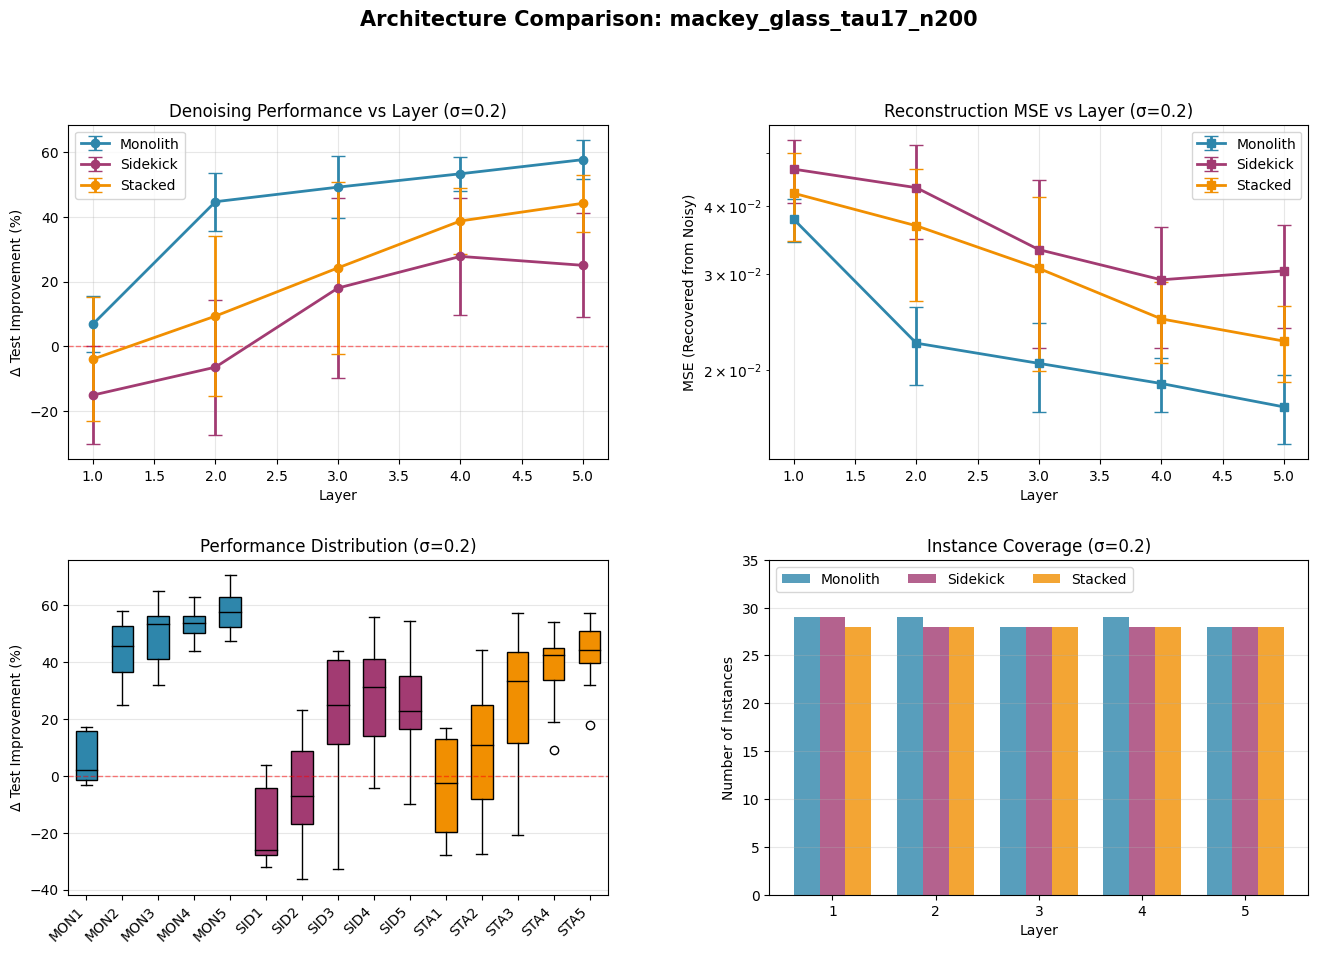

Saved comparison plot: eval_results/comparison_mackey_glass_tau30_n200_sigma0.20.png


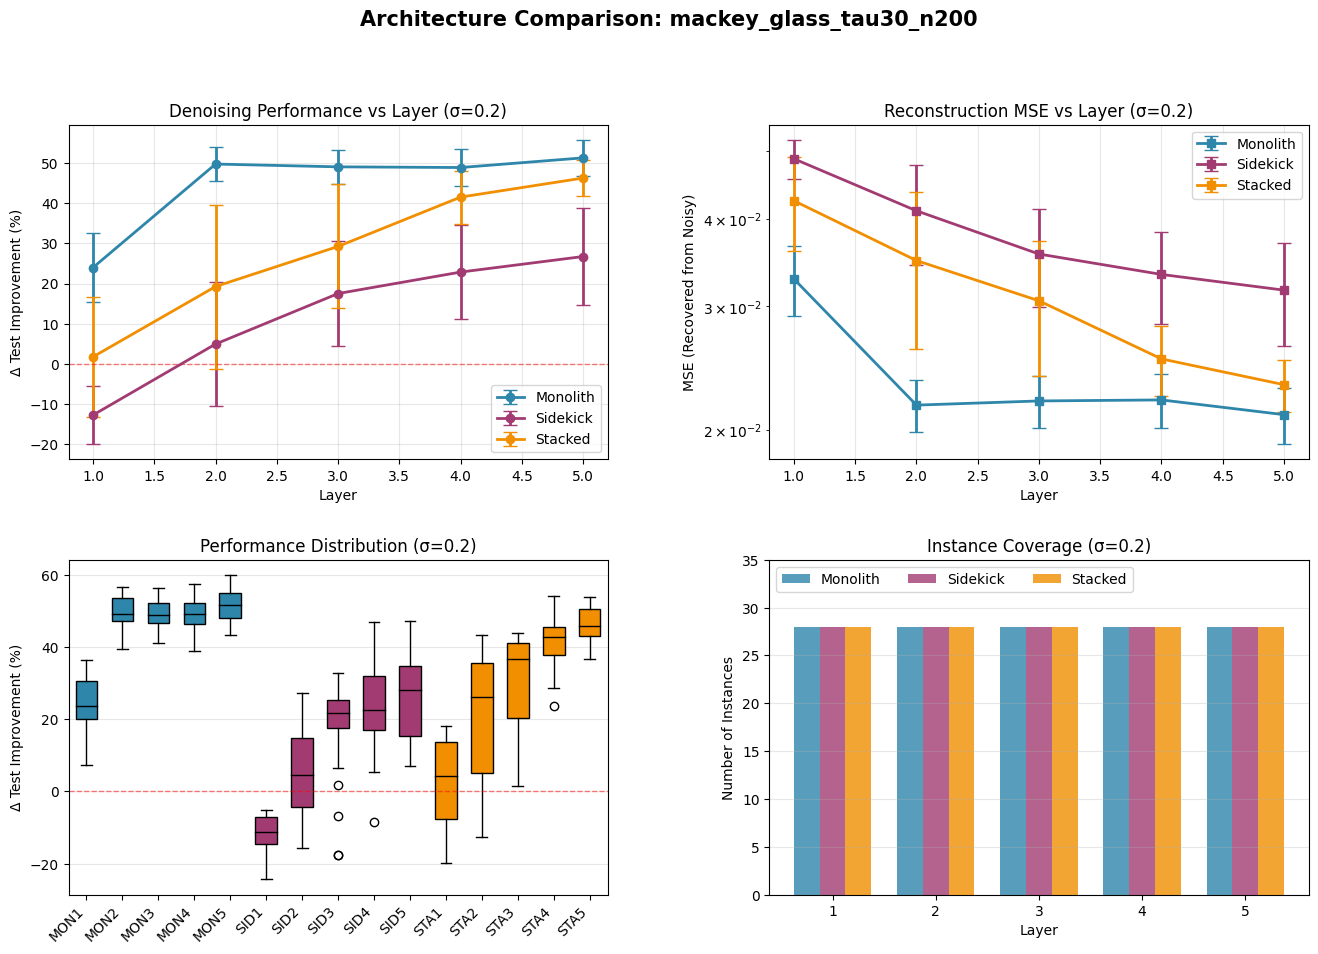

Saved representative pure plot: eval_results/representatives/repr_mackey_glass_tau17_n200_monolith_L1_inst4_sigma0.20_pure.png
Saved representative noisy plot: eval_results/representatives/repr_mackey_glass_tau17_n200_monolith_L1_inst4_sigma0.20_noisy.png
Saved representative pure plot: eval_results/representatives/repr_mackey_glass_tau17_n200_monolith_L2_inst2_sigma0.20_pure.png
Saved representative noisy plot: eval_results/representatives/repr_mackey_glass_tau17_n200_monolith_L2_inst2_sigma0.20_noisy.png
Saved representative pure plot: eval_results/representatives/repr_mackey_glass_tau17_n200_monolith_L3_inst4_sigma0.20_pure.png
Saved representative noisy plot: eval_results/representatives/repr_mackey_glass_tau17_n200_monolith_L3_inst4_sigma0.20_noisy.png
Saved representative pure plot: eval_results/representatives/repr_mackey_glass_tau17_n200_monolith_L4_inst7_sigma0.20_pure.png
Saved representative noisy plot: eval_results/representatives/repr_mackey_glass_tau17_n200_monolith_L4_in

In [11]:
# ===========================
# Cell 9 — Main Execution
# ===========================

def run_framework():
    """Main execution: discover, evaluate, aggregate, visualize."""
    
    print("\n" + "="*70)
    print("UNIVERSAL QAE EVALUATION FRAMEWORK")
    print("="*70)
    
    all_results = []
    dataset_cache: Dict[str, np.ndarray] = {}
    
    for dataset_id in DATASETS:
        print(f"\n{'-'*70}")
        print(f"DATASET: {dataset_id}")
        print(f"{'-'*70}")
        
        try:
            y_data, data_info = load_dataset(dataset_id)
            dataset_cache[dataset_id] = y_data
            print(f"Loaded {len(y_data)} samples from: {data_info['folder']}")
        except FileNotFoundError as e:
            print(f"{e}")
            continue
        
        bundles = find_bundles_for_dataset(dataset_id)
        total_bundles = sum(len(v) for v in bundles.values())
        print(f"Found {total_bundles} bundles:")
        for arch_type, paths in bundles.items():
            print(f"  {arch_type.capitalize()}: {len(paths)}")
        
        if total_bundles == 0:
            print(f"No bundles found for {dataset_id}, skipping.")
            continue
        
        print("Evaluating bundles...")
        for arch_type, bundle_paths in bundles.items():
            for bundle_path in sorted(bundle_paths):
                try:
                    result = evaluate_bundle(bundle_path, y_data)
                    all_results.append(result)
                except Exception as e:
                    print(f"  Error while evaluating {bundle_path.name}: {e}")
                    continue
    
    if len(all_results) == 0:
        print("\nNo results collected. Exiting.")
        return None
    
    print(f"\n{'-'*70}")
    print("AGGREGATING RESULTS")
    print(f"{'-'*70}")
    
    dfs = aggregate_results_by_architecture(all_results)
    
    # Save raw results
    for arch_type, df in dfs.items():
        out_path = Path(FRAMEWORK_OUT) / f"{arch_type}_raw_results.csv"
        df.to_csv(out_path, index=False)
        print(f"Saved raw results: {out_path}")
    
    # Compute statistics and representative models
    median_models_by_arch: Dict[str, pd.DataFrame] = {}
    for arch_type, df in dfs.items():
        stats = compute_architecture_statistics(df)
        out_stats = Path(FRAMEWORK_OUT) / f"{arch_type}_statistics.csv"
        stats.to_csv(out_stats, index=False)
        print(f"Saved statistics: {out_stats}")
        
        reps = find_representative_models(df)
        out_reps = Path(FRAMEWORK_OUT) / f"{arch_type}_representative_models.csv"
        reps.to_csv(out_reps, index=False)
        median_models_by_arch[arch_type] = reps
        print(f"Saved representative models: {out_reps}")
    
    # Plots
    if MAKE_PLOTS:
        print(f"\n{'-'*70}")
        print("GENERATING PLOTS")
        print(f"{'-'*70}")
        
        for dataset_id in DATASETS:
            for noise_level in TEST_NOISE_LEVELS:
                plot_path = Path(FRAMEWORK_OUT) / f"comparison_{dataset_id}_sigma{noise_level:.2f}.png"
                try:
                    plot_architecture_comparison(dfs, dataset_id, noise_level, plot_path)
                except Exception as e:
                    print(f"Comparison plot failed for {dataset_id}, σ={noise_level}: {e}")
        
        # Representative reconstructions
        try:
            plot_representative_reconstructions(
                all_results,
                median_models_by_arch,
                dataset_cache,
                Path(FRAMEWORK_OUT) / "representatives"
            )
        except Exception as e:
            print(f"Representative plots failed: {e}")
    
    print(f"\n{'='*70}")
    print("FRAMEWORK COMPLETE")
    print(f"{'='*70}")
    print(f"Results saved to: {FRAMEWORK_OUT}")
    
    return dfs


# Execute
results_dfs = run_framework()

In [12]:
# ===========================
# Cell 10 — Summary Analysis
# ===========================

def print_summary(dfs: Dict[str, pd.DataFrame]):
    """Print high-level summary of results."""
    
    print("\n" + "="*70)
    print("SUMMARY REPORT")
    print("="*70)
    
    for arch_type, df in dfs.items():
        print(f"\n{arch_type.upper()}")
        print(f"{'-'*70}")
        
        print(f"  Total evaluations: {len(df)}")
        print(f"  Datasets: {df['dataset'].nunique()}")
        print(f"  Unique architectures: {df.groupby(['n_qubits', 'n_latent', 'n_trash']).ngroups}")
        print(f"  Layer range: {df['layer'].min()} - {df['layer'].max()}")
        print(f"  Instance count: {df['instance_id'].nunique()}")
        
        print(f"\n  Performance metrics (mean ± std) by test noise:")
        for noise in sorted(df['test_noise'].unique()):
            noise_df = df[df['test_noise'] == noise]
            delta_mean = noise_df['delta_test_pct'].mean()
            delta_std = noise_df['delta_test_pct'].std()
            mse_mean = noise_df['mse_test_recovered_noisy'].mean()
            qmi_mean = noise_df.get('qmi_test', pd.Series([np.nan])).mean()
            print(f"    σ={noise:.2f}: Δ={delta_mean:+.2f}±{delta_std:.2f}%, "
                  f"MSE_rec={mse_mean:.6f}, QMI={qmi_mean:.3f}")
        
        print(f"\n  Best single model (by Δ_test_pct):")
        best = df.loc[df['delta_test_pct'].idxmax()]
        print(f"    Dataset: {best['dataset']}, Layer: {best['layer']}, Instance: {best['instance_id']}")
        print(f"    Test noise: σ={best['test_noise']:.2f}, Δ={best['delta_test_pct']:+.2f}%")
        print(f"    QMI={best.get('qmi_test', np.nan):.3f}")
    

if results_dfs:
    print_summary(results_dfs)


SUMMARY REPORT

MONOLITH
----------------------------------------------------------------------
  Total evaluations: 283
  Datasets: 2
  Unique architectures: 4
  Layer range: 1 - 5
  Instance count: 7

  Performance metrics (mean ± std) by test noise:
    σ=0.20: Δ=+43.42±16.46%, MSE_rec=0.023677, QMI=0.815

  Best single model (by Δ_test_pct):
    Dataset: mackey_glass_tau17_n200, Layer: 5, Instance: 7
    Test noise: σ=0.20, Δ=+70.68%
    QMI=0.000

SIDEKICK
----------------------------------------------------------------------
  Total evaluations: 281
  Datasets: 2
  Unique architectures: 4
  Layer range: 1 - 5
  Instance count: 7

  Performance metrics (mean ± std) by test noise:
    σ=0.20: Δ=+10.74±22.94%, MSE_rec=0.037367, QMI=0.452

  Best single model (by Δ_test_pct):
    Dataset: mackey_glass_tau17_n200, Layer: 4, Instance: 6
    Test noise: σ=0.20, Δ=+55.93%
    QMI=0.000

STACKED
----------------------------------------------------------------------
  Total evaluations: 2

# Software in use (Linux)

In [13]:
import os
os.system('pip list | grep -e pennylane -e torch');

pennylane                 0.42.3
pennylane_lightning       0.42.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
